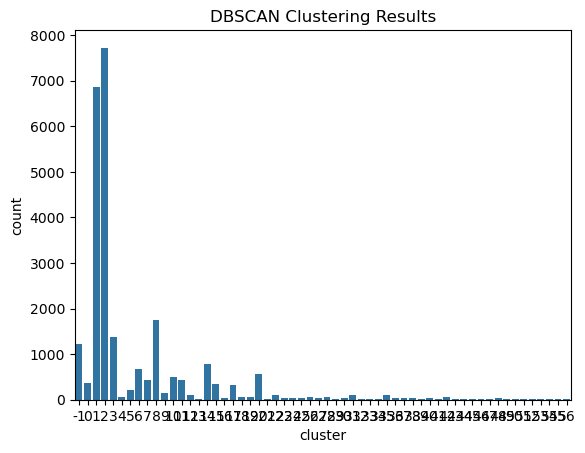

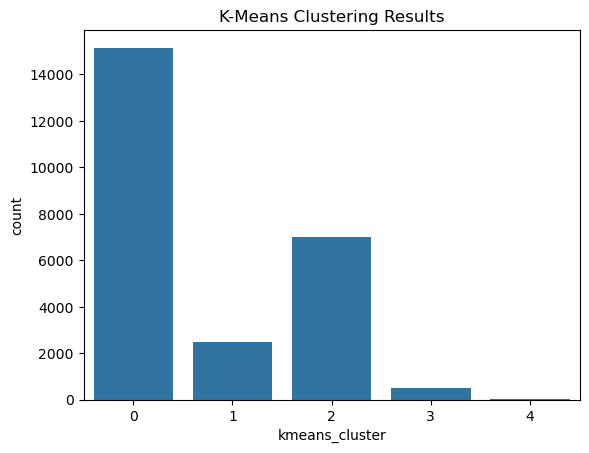

Silhouette Score for K-Means: 0.40664061668220464
Number of Anomalies Detected: 1233
     duration  protocol_type   service      flag  src_bytes  dst_bytes  \
1   -0.113551       2.215916  0.768925  0.753021  -0.010032  -0.039310   
25   0.075171      -0.126061  1.797514  0.753021  -0.009911   0.123036   
72  -0.113551      -2.468037  2.054662  0.753021  -0.010017  -0.039310   
100 -0.113551      -0.126061 -0.452524  0.753021  -0.010093  -0.035325   
111 -0.113551      -0.126061  1.411794  0.753021  -0.009226  -0.035538   

        land  wrong_fragment    urgent       hot  ...  \
1   -0.00891       -0.091223 -0.006301 -0.091933  ...   
25  -0.00891       -0.091223 -0.006301 -0.091933  ...   
72  -0.00891       -0.091223 -0.006301 -0.091933  ...   
100 -0.00891       -0.091223 -0.006301 -0.091933  ...   
111 -0.00891       -0.091223 -0.006301 -0.091933  ...   

     dst_host_same_src_port_rate  dst_host_srv_diff_host_rate  \
1                       2.375620                    -0.287993 

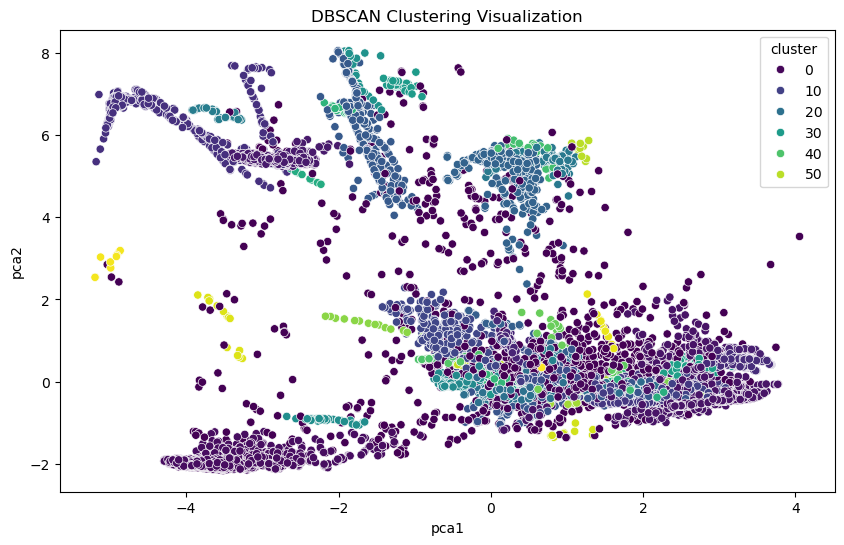

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import DBSCAN, KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset
columns = [
    "duration", "protocol_type", "service", "flag", "src_bytes", "dst_bytes",
    "land", "wrong_fragment", "urgent", "hot", "num_failed_logins", "logged_in",
    "num_compromised", "root_shell", "su_attempted", "num_root", "num_file_creations",
    "num_shells", "num_access_files", "num_outbound_cmds", "is_host_login",
    "is_guest_login", "count", "srv_count", "serror_rate", "srv_serror_rate",
    "rerror_rate", "srv_rerror_rate", "same_srv_rate", "diff_srv_rate", "srv_diff_host_rate",
    "dst_host_count", "dst_host_srv_count", "dst_host_same_srv_rate", "dst_host_diff_srv_rate",
    "dst_host_same_src_port_rate", "dst_host_srv_diff_host_rate", "dst_host_serror_rate",
    "dst_host_srv_serror_rate", "dst_host_rerror_rate", "dst_host_srv_rerror_rate", "attack_type", "label"
]

data = pd.read_csv(r"C:\Users\dell 3590\Downloads\archive (2)\KDDTrain+_20Percent.txt", names=columns)

# Encode categorical variables
categorical_columns = ["protocol_type", "service", "flag"]
label_encoders = {col: LabelEncoder() for col in categorical_columns}

for col in categorical_columns:
    data[col] = label_encoders[col].fit_transform(data[col])

# Select numerical columns
numerical_columns = data.select_dtypes(include=np.number).columns

# Standardize numerical data
scaler = StandardScaler()
data[numerical_columns] = scaler.fit_transform(data[numerical_columns])

# Apply DBSCAN
dbscan = DBSCAN(eps=1.5, min_samples=10)
data['cluster'] = dbscan.fit_predict(data[numerical_columns])

# Visualize clustering results
sns.countplot(x='cluster', data=data)
plt.title('DBSCAN Clustering Results')
plt.show()

# Apply K-Means
kmeans = KMeans(n_clusters=5, random_state=42)
data['kmeans_cluster'] = kmeans.fit_predict(data[numerical_columns])

# Visualize clustering results
sns.countplot(x='kmeans_cluster', data=data)
plt.title('K-Means Clustering Results')
plt.show()

# Silhouette Score for K-Means
silhouette_avg = silhouette_score(data[numerical_columns], data['kmeans_cluster'])
print(f"Silhouette Score for K-Means: {silhouette_avg}")

# Extract anomalies
anomalies = data[data['cluster'] == -1]
print(f"Number of Anomalies Detected: {len(anomalies)}")

# Analyze anomalies
print(anomalies.head())

from sklearn.decomposition import PCA

# Reduce dimensions for visualization
pca = PCA(n_components=2)
pca_data = pca.fit_transform(data[numerical_columns])

# Add PCA results to data
data['pca1'] = pca_data[:, 0]
data['pca2'] = pca_data[:, 1]

# Plot clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x='pca1', y='pca2', hue='cluster', data=data, palette='viridis')
plt.title('DBSCAN Clustering Visualization')
plt.show()


In [3]:
# Define attack categories
attack_mapping = {
    'normal': 'Normal',
    # DoS attacks
    'back': 'DoS', 'land': 'DoS', 'neptune': 'DoS', 'pod': 'DoS',
    'smurf': 'DoS', 'teardrop': 'DoS',
    # Probe attacks
    'ipsweep': 'Probe', 'nmap': 'Probe', 'portsweep': 'Probe', 'satan': 'Probe',
    # U2R attacks
    'buffer_overflow': 'U2R', 'loadmodule': 'U2R', 'perl': 'U2R', 'rootkit': 'U2R',
    # R2L attacks
    'ftp_write': 'R2L', 'guess_passwd': 'R2L', 'imap': 'R2L', 'multihop': 'R2L',
    'phf': 'R2L', 'spy': 'R2L', 'warezclient': 'R2L', 'warezmaster': 'R2L'
}

# Map attack types to broader categories
data['attack_category'] = data['attack_type'].map(attack_mapping)

# Verify the mapping
print(data['attack_category'].value_counts())


attack_category
Normal    13449
DoS        9234
Probe      2289
R2L         209
U2R          11
Name: count, dtype: int64


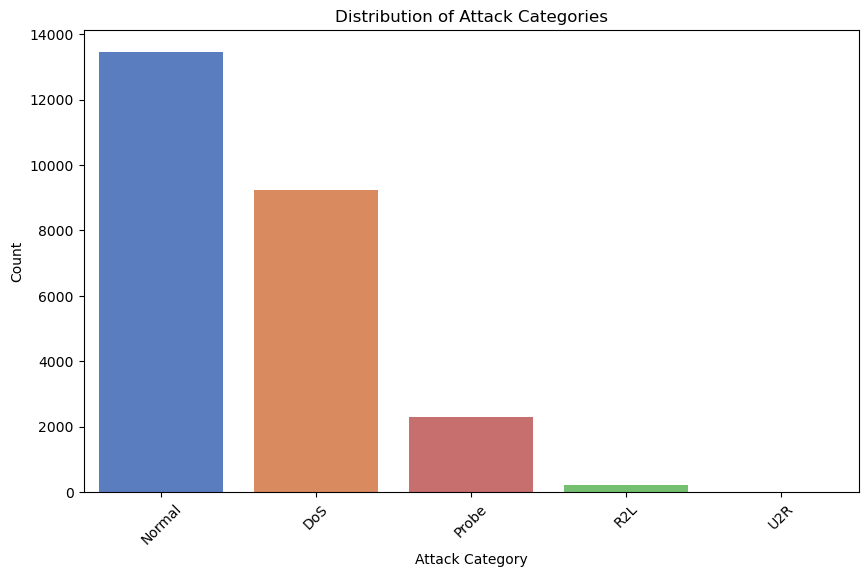

In [4]:
plt.figure(figsize=(10, 6))
sns.countplot(
    x='attack_category',
    data=data,
    order=data['attack_category'].value_counts().index,
    hue='attack_category',
    palette='muted',
    dodge=False,  # Ensures no separation between bars
    legend=False
)
plt.title('Distribution of Attack Categories')
plt.xlabel('Attack Category')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()


In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder

# Load the dataset
columns = [
    "duration", "protocol_type", "service", "flag", "src_bytes", "dst_bytes",
    "land", "wrong_fragment", "urgent", "hot", "num_failed_logins", "logged_in",
    "num_compromised", "root_shell", "su_attempted", "num_root", "num_file_creations",
    "num_shells", "num_access_files", "num_outbound_cmds", "is_host_login",
    "is_guest_login", "count", "srv_count", "serror_rate", "srv_serror_rate",
    "rerror_rate", "srv_rerror_rate", "same_srv_rate", "diff_srv_rate", "srv_diff_host_rate",
    "dst_host_count", "dst_host_srv_count", "dst_host_same_srv_rate", "dst_host_diff_srv_rate",
    "dst_host_same_src_port_rate", "dst_host_srv_diff_host_rate", "dst_host_serror_rate",
    "dst_host_srv_serror_rate", "dst_host_rerror_rate", "dst_host_srv_rerror_rate", "attack_type", "label"
]

# Load dataset from CSV
data = pd.read_csv(r"C:\Users\dell 3590\Downloads\archive (2)\KDDTrain+_20Percent.txt", names=columns)

# Encode categorical variables (protocol_type, service, flag)
categorical_columns = ['protocol_type', 'service', 'flag']
label_encoders = {col: LabelEncoder() for col in categorical_columns}

for col in categorical_columns:
    data[col] = label_encoders[col].fit_transform(data[col])

# Define features and target
X = data.drop(['attack_type', 'label'], axis=1)  # Drop target columns
y = data['attack_type']  # The attack type as the target

# Split the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the Random Forest Classifier
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))



Accuracy: 0.9964

Classification Report:
                 precision    recall  f1-score   support

           back       1.00      1.00      1.00        36
buffer_overflow       1.00      1.00      1.00         1
   guess_passwd       1.00      1.00      1.00         2
        ipsweep       1.00      0.98      0.99       147
     loadmodule       0.00      0.00      0.00         1
        neptune       1.00      1.00      1.00      1694
           nmap       0.98      1.00      0.99        51
         normal       1.00      1.00      1.00      2674
            pod       1.00      1.00      1.00        10
      portsweep       0.99      0.98      0.99       117
          satan       0.98      0.97      0.98       130
          smurf       1.00      0.99      1.00       114
            spy       0.00      0.00      0.00         1
       teardrop       1.00      1.00      1.00        31
    warezclient       0.93      0.96      0.95        28
    warezmaster       1.00      1.00      1.00

F:\jupiter\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
F:\jupiter\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
F:\jupiter\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [2]:
from sklearn.metrics import classification_report

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, zero_division=1))  # Setting zero_division to handle precision issues


Accuracy: 0.9964

Classification Report:
                 precision    recall  f1-score   support

           back       1.00      1.00      1.00        36
buffer_overflow       1.00      1.00      1.00         1
   guess_passwd       1.00      1.00      1.00         2
        ipsweep       1.00      0.98      0.99       147
     loadmodule       1.00      0.00      0.00         1
        neptune       1.00      1.00      1.00      1694
           nmap       0.98      1.00      0.99        51
         normal       1.00      1.00      1.00      2674
            pod       1.00      1.00      1.00        10
      portsweep       0.99      0.98      0.99       117
          satan       0.98      0.97      0.98       130
          smurf       1.00      0.99      1.00       114
            spy       1.00      0.00      0.00         1
       teardrop       1.00      1.00      1.00        31
    warezclient       0.93      0.96      0.95        28
    warezmaster       1.00      1.00      1.00

In [3]:
from sklearn.model_selection import GridSearchCV

# Hyperparameter tuning using GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

# Best parameters from grid search
print("Best Parameters: ", grid_search.best_params_)

# Best model from grid search
best_model = grid_search.best_estimator_

# Evaluate the best model
best_y_pred = best_model.predict(X_test)
print(f"Accuracy of Best Model: {accuracy_score(y_test, best_y_pred):.4f}")


Fitting 5 folds for each of 36 candidates, totalling 180 fits


F:\jupiter\Lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Best Parameters:  {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 100}
Accuracy of Best Model: 0.9966


In [8]:
import joblib

# Save the trained model
joblib.dump(best_model, 'random_forest_model.pkl')

# To load the saved model
loaded_model = joblib.load('random_forest_model.pkl')

# Make predictions with the loaded model
loaded_y_pred = loaded_model.predict(X_test)


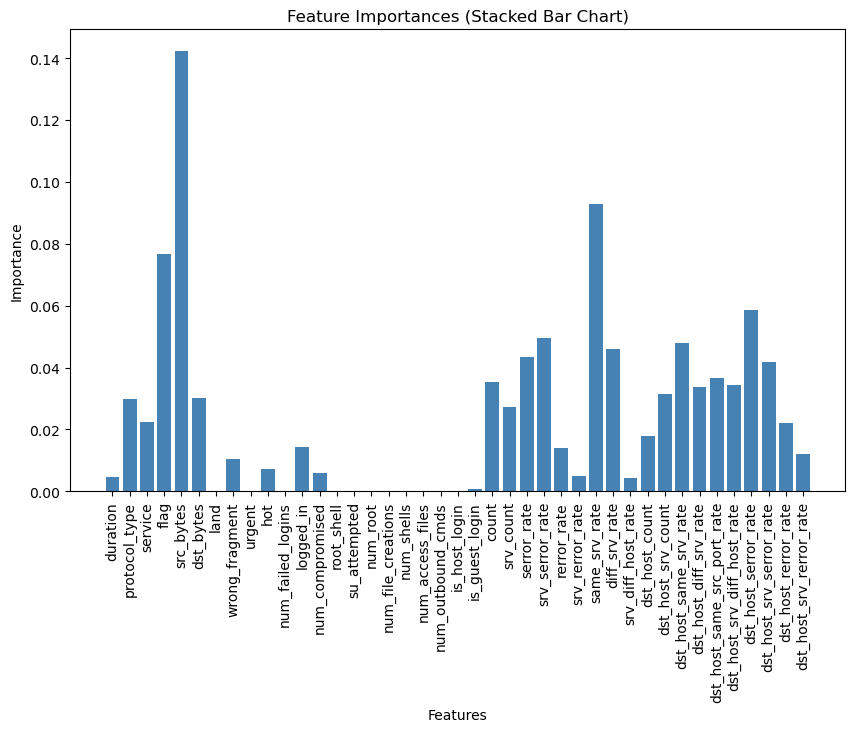

In [9]:
# Convert feature importances to a DataFrame
feature_importances = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': best_model.feature_importances_
})

# Plot a stacked bar chart for feature importance
plt.figure(figsize=(10, 6))
plt.bar(feature_importances['Feature'], feature_importances['Importance'], color='steelblue')
plt.xticks(rotation=90)
plt.title('Feature Importances (Stacked Bar Chart)')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.show()


In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

# Load the dataset
columns = [
    "duration", "protocol_type", "service", "flag", "src_bytes", "dst_bytes",
    "land", "wrong_fragment", "urgent", "hot", "num_failed_logins", "logged_in",
    "num_compromised", "root_shell", "su_attempted", "num_root", "num_file_creations",
    "num_shells", "num_access_files", "num_outbound_cmds", "is_host_login",
    "is_guest_login", "count", "srv_count", "serror_rate", "srv_serror_rate",
    "rerror_rate", "srv_rerror_rate", "same_srv_rate", "diff_srv_rate", "srv_diff_host_rate",
    "dst_host_count", "dst_host_srv_count", "dst_host_same_srv_rate", "dst_host_diff_srv_rate",
    "dst_host_same_src_port_rate", "dst_host_srv_diff_host_rate", "dst_host_serror_rate",
    "dst_host_srv_serror_rate", "dst_host_rerror_rate", "dst_host_srv_rerror_rate", "attack_type", "label"
]

# Assuming your dataset is in the path specified, replace with the correct path
data = pd.read_csv(r"C:\Users\dell 3590\Downloads\archive (2)\KDDTrain+_20Percent.txt", names=columns)

# Select relevant features
features = [
    'logged_in', 'attack_type', 'num_failed_logins', 'hot', 'num_access_files'
]

# Select target variable (let's assume we are predicting 'logged_in' status)
target = 'logged_in'

# Encode categorical features using LabelEncoder
label_encoder = LabelEncoder()

# Encode the 'attack_type' feature
data['attack_type'] = label_encoder.fit_transform(data['attack_type'])

# Select the features and target columns
X = data[features]
y = data[target]

# Standardize numerical features
scaler = StandardScaler()
# Convert the columns to float before assigning the transformed values
X[['num_failed_logins', 'hot', 'num_access_files']] = X[['num_failed_logins', 'hot', 'num_access_files']].astype(float)
X.loc[:, ['num_failed_logins', 'hot', 'num_access_files']] = scaler.fit_transform(X[['num_failed_logins', 'hot', 'num_access_files']])



# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Random Forest Classifier
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

# Display classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))



C:\Users\dell 3590\AppData\Local\Temp\ipykernel_696\238293368.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[['num_failed_logins', 'hot', 'num_access_files']] = X[['num_failed_logins', 'hot', 'num_access_files']].astype(float)


Accuracy: 100.00%

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3030
           1       1.00      1.00      1.00      2009

    accuracy                           1.00      5039
   macro avg       1.00      1.00      1.00      5039
weighted avg       1.00      1.00      1.00      5039



Accuracy: 100.00%

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3030
           1       1.00      1.00      1.00      2009

    accuracy                           1.00      5039
   macro avg       1.00      1.00      1.00      5039
weighted avg       1.00      1.00      1.00      5039



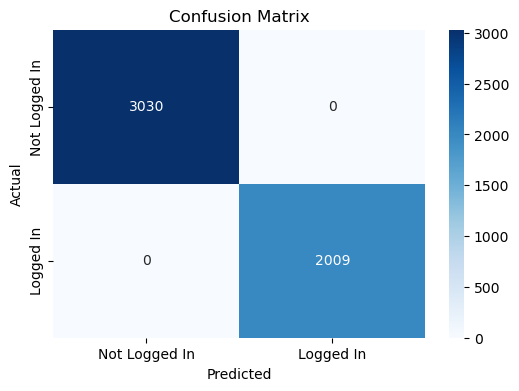

In [5]:
# Test the trained model on the test set

# Make predictions on the test data
y_pred = model.predict(X_test)

# Evaluate the model performance
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

# Display classification report for detailed metrics
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix for a more detailed view of prediction results
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Logged In', 'Logged In'], yticklabels=['Not Logged In', 'Logged In'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()



In [6]:
import joblib
from sklearn.preprocessing import LabelEncoder

# Create and fit the label encoder
label_encoder = LabelEncoder()
label_encoder.fit(['DoS', 'Probe', 'U2R', 'R2L'])  # Use the categories you trained the encoder with

# Save the label encoder to a file
joblib.dump(label_encoder, 'label_encoder.pkl')


['label_encoder.pkl']


Sum of columns:
num_failed_logins        30
hot                    4989
num_access_files        109
attack_type          265326
dtype: int64


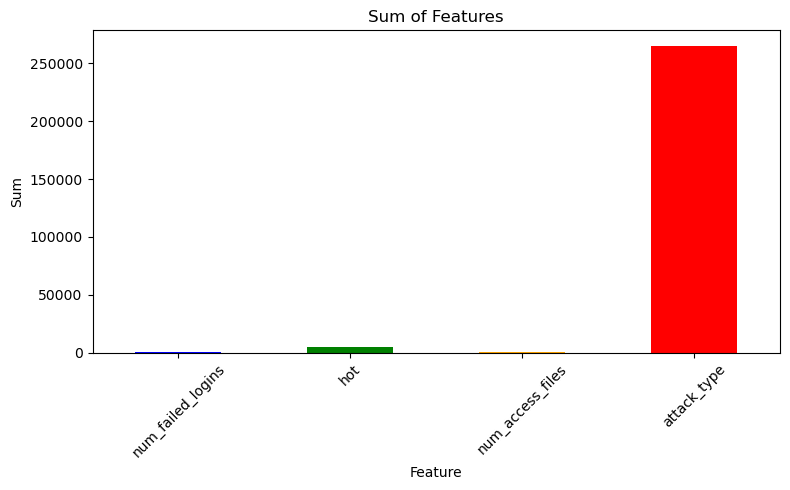


Accuracy: 55.32%


['random_forest_model.pkl']

In [8]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import joblib
import matplotlib.pyplot as plt

# Load the dataset (adjust the path to your dataset)
data = pd.read_csv(r"C:\Users\dell 3590\Downloads\KDDTrain_Encoded.csv")

# Filter the dataset to only use the 4 features and the target variable
features = ['num_failed_logins', 'hot', 'num_access_files', 'attack_type']
target = 'label'  # Assuming 'label' is the target variable in your dataset

# Extract features and target
X = data[features]
y = data[target]

# Calculate the sum of the selected features
column_sums = X.sum()
print("\nSum of columns:")
print(column_sums)

# Create a bar plot of the column sums
plt.figure(figsize=(8, 5))
column_sums.plot(kind='bar', color=['blue', 'green', 'orange', 'red'])
plt.title('Sum of Features')
plt.ylabel('Sum')
plt.xlabel('Feature')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('feature_sums_bar_plot.png')  # Save the bar plot as an image file
plt.show()

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize and train the RandomForestClassifier
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'\nAccuracy: {accuracy * 100:.2f}%')

# Save the trained model to a file
joblib.dump(model, 'random_forest_model.pkl')

# Optionally save the label encoder if needed (depends on your dataset)
# joblib.dump(label_encoder, 'model/label_encoder.pkl')
